# Simple Neural Network

1. Basic pipeline
1. Sequential NN for binary classification
    1. First layer - 32 nodes, input_dim=400 - use raw data
    1. Second layer - 16 nodes
    1. Output layer - 1 node
1. Gradient Descent optimizaion : adam
1. Binary Cross Entropy loss function : binary classification
1. Accuracy metric

## Imports and Globals

In [1]:
from collections import namedtuple
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import font_utils.load_font as LF

TRIMMED_PATH='/data/udel-ms-data-science/math-637/project-1/char-fonts/trimmed'
ALL_FONTS_CSV=f'{TRIMMED_PATH}/all_fonts.csv'

DATA_COLS=[f'r{row}c{col}' for row in range(20) for col in range(20)]
TARGET_COL=['font_class']
META_COLS=['m_label', 'font', 'variant']

## Read All Font Data

In [2]:
all_df = pd.read_csv(ALL_FONTS_CSV).drop('Unnamed: 0', axis=1)
all_df.dtypes

m_label        int64
r0c0           int64
r0c1           int64
r0c2           int64
r0c3           int64
               ...  
r19c18         int64
r19c19         int64
font          object
variant       object
font_class    object
Length: 404, dtype: object

### Create DataFrames for raw data

1. Randomly shuffle the data first to mix the classes within the data set
1. m_label - the character encoded as ASCII
1. font
1. font variant
1. class_label (TARGET)
    1. 1 - The font character is the given font class
    1. 0 - The font character is not the given font class
1. r0c0...r19c19 (400 elements in raw image data)

In [3]:
class_counts = {
    cc_i:cc_v for cc_i, cc_v in all_df.groupby(by='font_class').count().m_label.items()
}

BY_CLASS = {c:all_df.loc[all_df.font_class == c] for c in ['mo', 'os', 'ss', 'tr']}

WITHOUT = {
    'mo' : ['os', 'ss', 'tr'],
    'os' : ['mo', 'ss', 'tr'],
    'ss' : ['mo', 'os', 'tr'],
    'tr' : ['mo', 'os', 'ss']    
}

RAW_INPUT_DICT = dict()
for k,v in class_counts.items():
    one_third = int(v/3)
#     print(f'{k} : {v} : {one_third} : {WITHOUT[k]}')
    others = list()
    for c in WITHOUT[k]:
        others.append(BY_CLASS[c].sample(frac=float(one_third/class_counts[c])).reset_index(drop=True))
    others.append(BY_CLASS[k])
#     print(f'Len of others {len(others)}')
    t_df = pd.DataFrame().append(others).sample(frac=1).reset_index(drop=True)
    t_df['font_class'] = np.where(t_df.font_class == k, 1, 0)
    t_df['font_class'] = t_df['font_class'].astype(int)
    RAW_INPUT_DICT[k] = t_df
    
for c, df in RAW_INPUT_DICT.items():
    print(f'{c} {df.shape}')

mo (3470, 404)
os (2726, 404)
ss (5702, 404)
tr (2479, 404)


## Split Data Into Train/Test

1. X cols: r0c0,...,r19c19
1. Y cols: font_class
1. Others: m_label, font, variant

In [4]:
IN_DATA = dict()
for k,df in RAW_INPUT_DICT.items():
    x = df.loc[:, DATA_COLS]
    y = df.loc[:, TARGET_COL]
    m = df.loc[:, META_COLS]

    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
#     X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    
    i_data = dict()
    i_data['train_x'] = X_train
    i_data['train_y'] = Y_train
#     i_data['val_x']   = X_val
#     i_data['val_y']   = Y_val
    i_data['test_x'] = X_test
    i_data['test_y'] = Y_test
    
    IN_DATA[k] = i_data

## Setup Sequential Neural Network

In [5]:
def plot_cm(nn_m, in_data, font_class):
    #  Confusion Matrix
    y_test_pred = nn_m.predict_classes(in_data['test_x'])
    c_matrix = confusion_matrix(in_data['test_y'], y_test_pred)
    ax = sns.heatmap(
        c_matrix, 
        annot=True,
        xticklabels=[f'Not {font_class}', f'{font_class}'],
        yticklabels=[f'Not {font_class}', f'{font_class}'],
        cbar=False,
        cmap='Blues',
        fmt='g'
    )
    ax.set_title(f'Confusion Matrix {font_class}')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')
    plt.savefig(f'Simple_CM_{font_class.replace(" ","_")}.pdf')
    plt.show()
    
def plot_roc(nn_m, in_data, font_class):
    # ROC Curve
    y_test_pred_probs = nn_m.predict(in_data['test_x'])
    fpr, tpr, _ = roc_curve(in_data['test_y'], y_test_pred_probs)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--', color='black')
    plt.title(f'ROC Curve {font_class}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig(f'Simple_ROC_{font_class.replace(" ","_")}.pdf')
    plt.show()
    
def run_sequential(in_data, font_class):
    l1_nodes = 32
    l2_nodes = 16
    i_dims   = 400
    t_epochs = 200
    
    # Setup Sequential Neural Network
    nn = Sequential()
    nn.add(Dense(l1_nodes, activation='relu',input_dim=i_dims))
    nn.add(Dense(l2_nodes, activation='relu'))
    nn.add(Dense(1,activation='sigmoid'))

    nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    print(f'Start {datetime.now()}')
    nn.fit(in_data['train_x'],in_data['train_y'], epochs=t_epochs,verbose=0)
    print(f'Stop  {datetime.now()}')

    scores = nn.evaluate(in_data['train_x'],in_data['train_y'])
    print(f'Training Accurancy {scores[1]*100}')

    scores = nn.evaluate(in_data['test_x'],in_data['test_y'])
    print(f'Test Accurancy {scores[1]*100}')
    
    #fig, axs = plt.subplots(1,2)
    
    plot_cm(nn, in_data, font_class)
    plot_roc(nn, in_data, font_class)

Start 2021-05-23 21:32:11.529898
Stop  2021-05-23 21:32:19.591882
87/87 [==============================] - 0s 474us/step - loss: 0.2489 - accuracy: 0.9258
Training Accurancy 92.57925152778625
22/22 [==============================] - 0s 592us/step - loss: 1.7555 - accuracy: 0.7579
Test Accurancy 75.79250931739807
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


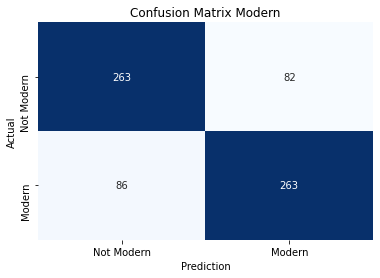

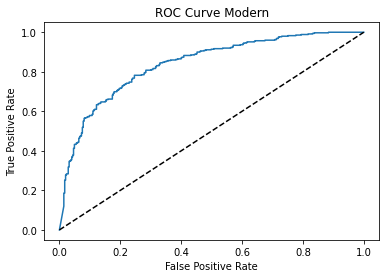

Start 2021-05-23 21:32:20.138382
Stop  2021-05-23 21:32:26.845547
69/69 [==============================] - 0s 510us/step - loss: 0.1809 - accuracy: 0.9431
Training Accurancy 94.31192874908447
18/18 [==============================] - 0s 599us/step - loss: 1.3350 - accuracy: 0.6996
Test Accurancy 69.96337175369263


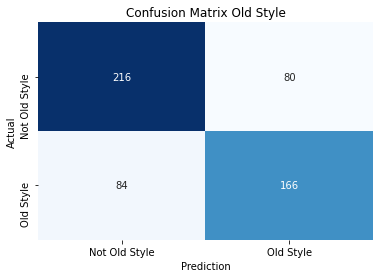

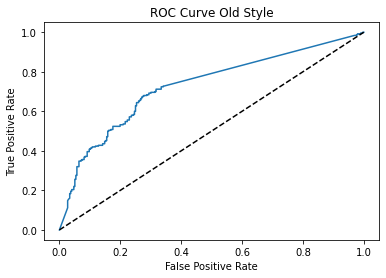

Start 2021-05-23 21:32:27.291949
Stop  2021-05-23 21:32:42.250452
143/143 [==============================] - 0s 485us/step - loss: 0.0283 - accuracy: 0.9914
Training Accurancy 99.1449236869812
36/36 [==============================] - 0s 541us/step - loss: 0.4045 - accuracy: 0.9430
Test Accurancy 94.3032443523407


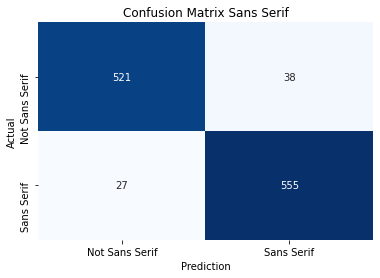

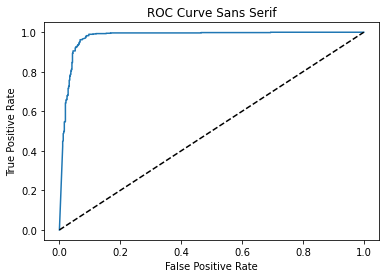

Start 2021-05-23 21:32:42.872905
Stop  2021-05-23 21:32:49.682163
62/62 [==============================] - 0s 517us/step - loss: 0.0931 - accuracy: 0.9682
Training Accurancy 96.82299494743347
16/16 [==============================] - 0s 518us/step - loss: 2.0156 - accuracy: 0.7419
Test Accurancy 74.19354915618896


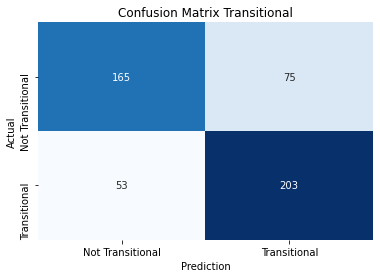

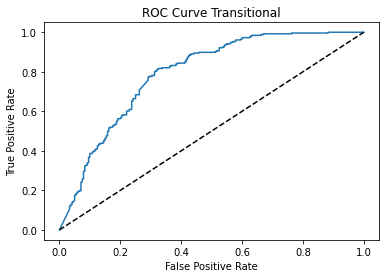

In [6]:
tag_lu = {
    'os': 'Old Style',
    'tr': 'Transitional',
    'mo': 'Modern',
    'ss': 'Sans Serif'
}

for k,v in IN_DATA.items():
    run_sequential(v, tag_lu[k])